# Task 4

Find the lowest eigenvalue of the following matrix:

$$
\begin{pmatrix}
    1 & 0 & 0 & 0 \\
    0 & 0 & -1 & 0 \\
    0 & -1 & 0 & 0 \\
    0 & 0 & 0 & 1
\end{pmatrix}
$$

using VQE-like circuits, created by yourself from scratch.


In [1]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.aqua.operators import I, X, Y, Z
import numpy as np
from matplotlib import pyplot as plt

## Pauli decomposition

In [2]:
def pauli_ops(n):
    from itertools import product
    from functools import reduce
    
    basis1 = [I, X, Y, Z]
    
    basis_n_lists = product([g for g in basis1], repeat=n)
    
    basis_n = [reduce(lambda g, h: g^h, l) for l in basis_n_lists]

    return basis_n

def basis_change_matrix(M):
    M_t = np.vstack(tuple(g.flatten() for g in M))
    return M_t.T

def to_pauli_op(A):
    from math import log2
    
    n = log2(len(A))
    
    m, k = A.shape
    if not n.is_integer() or m != k:
        raise ValueError('Pauli decomposition is only possible for 2^n x 2^n matrices')
    
    basis_ops = pauli_ops(int(n))
    
    M = basis_change_matrix([op.to_matrix() for op in basis_ops])
    
    coeffs = np.linalg.solve(M, A.flatten())
    
    d = [c * op for c, op in zip(coeffs, basis_ops) if c != 0]

    return sum(d)

In [3]:
H = np.array([
    [1, 0, 0, 0], 
    [0, 0, -1, 0],
    [0, -1, 0, 0], 
    [0, 0, 0, 1]
])

Hop = to_pauli_op(H)
print(Hop)

SummedOp([
  (0.5+0j) * II,
  (-0.5+0j) * XX,
  (-0.5-0j) * YY,
  (0.5+0j) * ZZ
])


In [4]:
def ansatz(qc, params):
    qc.h(0)
    qc.cx(0, 1)
    qc.rx(params[0], 0)
    

def rot_measure(qc, term):
    label = term.primitive.to_label()
    for i, g in enumerate(label):
        {
            'I': lambda: None,
            'X': lambda: qc.u2(0, np.pi, i),
            'Y': lambda: qc.u2(0, np.pi/2, i),
            'Z': lambda: None
        }[g]()
        

In [5]:
def term_circuit(term, params, varform=ansatz):
    qc = QuantumCircuit(term.num_qubits)

    varform(qc, params)
    qc.barrier()

    rot_measure(qc, term)
    qc.measure_all()

    return qc

def state_to_value(state):
    v = 1
    for s in state:
        v *= 1 if s=='0' else -1
    return v

def process_I(Hop):
    In = I^Hop.num_qubits
    
    ops = []
    eI = 0
    for op in Hop:
        if op.primitive == In.primitive:
            eI = op.coeff
        else:
            ops.append(op)
    return eI, sum(ops)   

def energy(Hop, varform, params, shots):
    e, Hs = process_I(Hop)
    circuits = [term_circuit(op, params, varform) for op in Hop]
    for op, qc in zip(Hop, circuits):
        job = execute(qc, Aer.get_backend('qasm_simulator'), shots=shots)
        counts = job.result().get_counts()
        e_i = 0
        for state, freq in counts.items():
            e_i += state_to_value(state) * freq / shots
        e += op.coeff * e_i
    return e

In [6]:
def vqe(Hop, varform=ansatz, shots=100):
    es = []
    for i in range(1000):
        t = 2*np.pi*i/1000
        e = energy(Hop, varform, [t], shots)
        es.append(e)
        
    return es

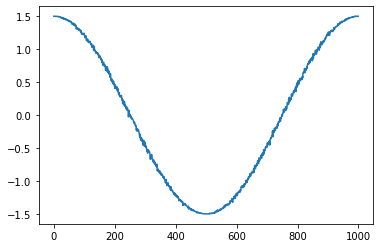

In [7]:
es = [e.real for e in vqe(Hop, shots=1000)]
plt.plot(es)

In [8]:
from qiskit.aqua.algorithms import NumPyEigensolver

real = NumPyEigensolver(Hop).run()
real['eigenvalues']

found_eig = min(es)
real_eig = min([e.real for e in real['eigenvalues']])

print(found_eig, real_eig)
print('error', abs(found_eig-real_eig))

-1.5 -1.0000000000000002
error 0.4999999999999998


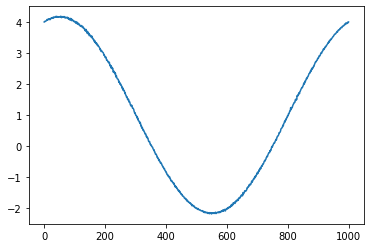

In [9]:
def little_var(qc, params):
    qc.ry(params[0], 0)

h = np.array([
    [3, 1],
    [1, -1]
])
hop = to_pauli_op(h)
es = [e.real for e in vqe(hop, little_var, shots=10000)]
plt.plot(es)

In [10]:
print(hop)

real = NumPyEigensolver(hop).run()
real['eigenvalues']

found_eig = min(es)
real_eig = min([e.real for e in real['eigenvalues']])

print(found_eig, real_eig)
print('error', abs(found_eig-real_eig))

SummedOp([
  I,
  X,
  (2+0j) * Z
])
-2.1852 -1.2360679774997896
error 0.9491320225002104
